# Plotting Sentiment Ranking Charts

The notebook visualizes the Google Play Top Grossing rankings for Genshin Impact and Fate/Grand Order overlaid with the times chen character banners released. It also calculates the statistical significance of the differences before and after each banner.

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Ranking Data

In [2]:
#get ranking data
df1 = pd.read_csv('sensor_tower_1.csv')
df2 = pd.read_csv('sensor_tower_2.csv')
df3 = pd.read_csv('sensor_tower_3.csv')

#combine data into one dataframe
rank_df = pd.concat([df1, df2, df3])

#turn dates into datetime format
rank_df['Date'] = pd.to_datetime(rank_df['Date'])

#pivot data
rank_df = rank_df.pivot(index = 'Date', columns = 'App Name', values = 'topgrossing')

## Genshin Impact

### Create Dataframe

In [3]:
#get sentiment data for Genshin Impact
gi_df = pd.read_pickle('pickle/com.miHoYo.GenshinImpact.pkl')
gi_df = gi_df[['at','sentiment']]
gi_df = gi_df.groupby([gi_df['at'].dt.date, 'sentiment']).count().unstack(0).transpose().reset_index().drop(columns = 'level_0')
gi_df.index = gi_df.set_index('at').index.set_names('Date')
gi_sent_df = gi_df.drop(columns = 'at')
gi_sent_df.index = pd.to_datetime(gi_sent_df.index)
gi_sent_df = gi_sent_df.fillna(0)

#combine ranking and sentiment dataframes
gi_rank_df = rank_df[['Genshin Impact']].rename(columns = {'Genshin Impact':'rank'})
gi_df = gi_rank_df.merge(gi_sent_df, on = 'Date')
gi_df['sentiment_count'] = gi_df['negative'] + gi_df['neutral'] + gi_df['positive']

### Create Plot

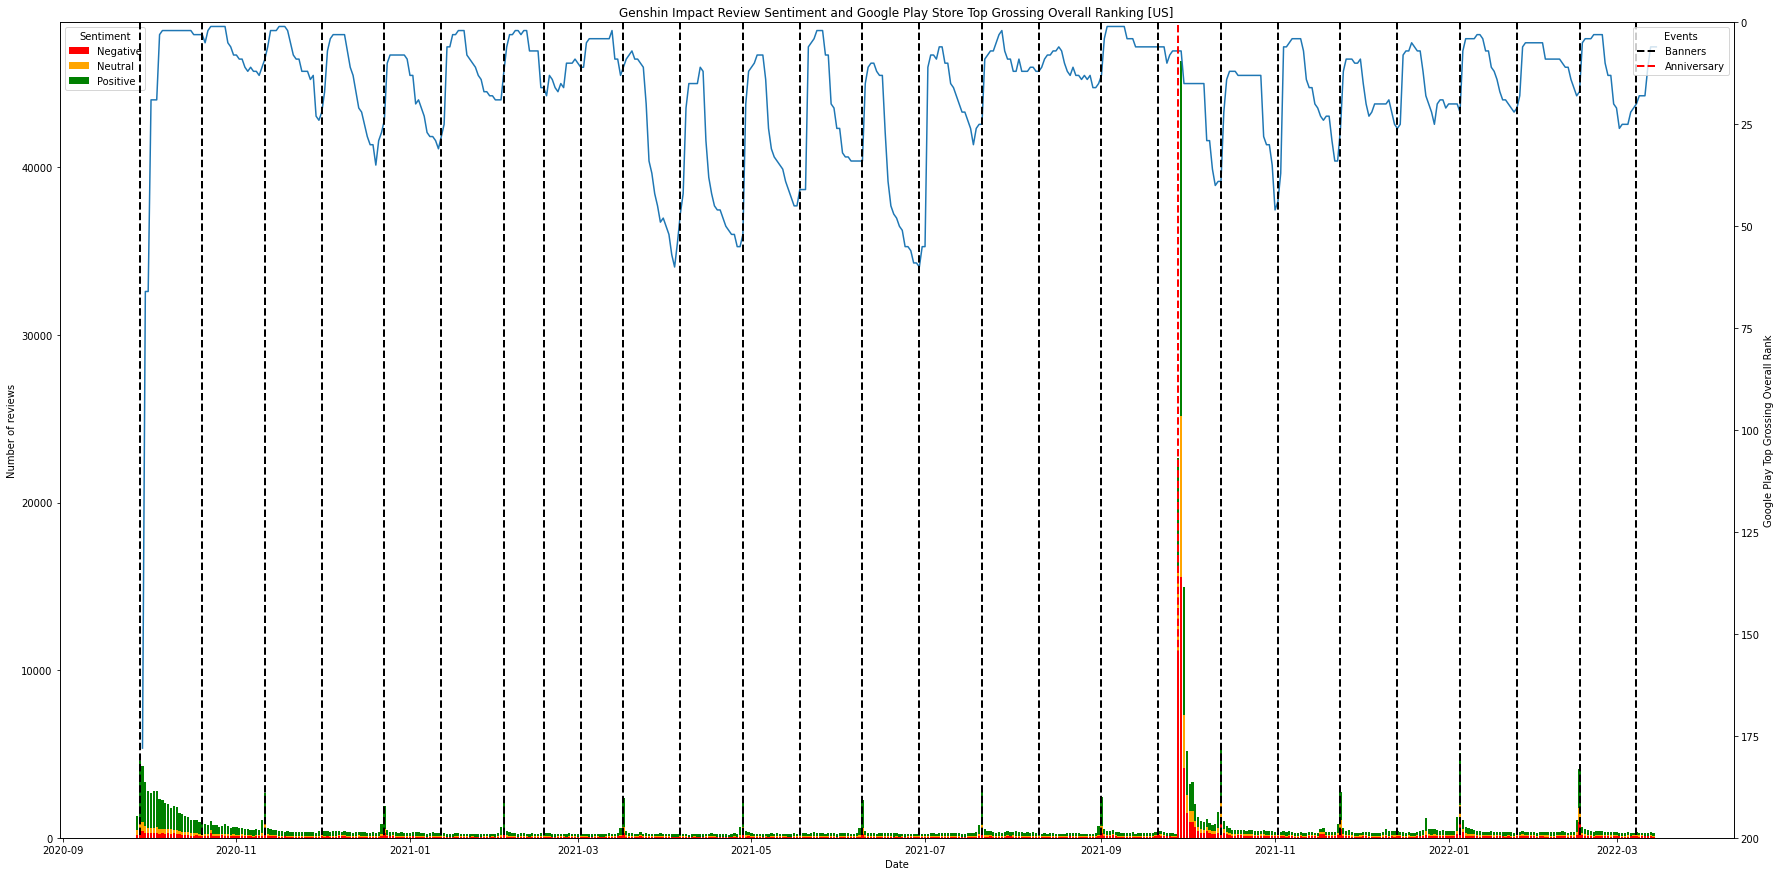

In [4]:
#get Genshin Impact events
events_df = pd.read_csv('Genshin Impact Events Calendar.csv').rename(columns = {'Version':'event_type', 'Start':'date'})
events_df = events_df[['date', 'event_type','Name']].dropna()
events_df['date'] = pd.to_datetime(events_df['date'])

fig, ax = plt.subplots(figsize=(30,15))

#plot sentiment
ax.bar(gi_df.index, gi_df['negative'], label='Negative', color = 'red')
ax.bar(gi_df.index, gi_df['neutral'], bottom=gi_df['negative'], color = 'orange',
       label='Neutral')
ax.bar(gi_df.index, gi_df['positive'], bottom=gi_df['negative']+gi_df['neutral'],
       label='Positive', color = 'green')
ax.set_xlabel('Date')
ax.set_ylabel('Number of reviews')
ax.legend(loc = 2, title = 'Sentiment')

#plot ranking
ax2 = ax.twinx()
ax2.plot(gi_df.index, gi_df['rank'])
ax2.set_ylabel('Google Play Top Grossing Overall Rank')
ax2.invert_yaxis()

#plot banners/anniversary
#character banners
ax2.vlines(events_df[events_df['event_type'] == 'Test Run Event']['date'], 
           ymin=0, ymax=200, color='k', linestyle='--', lw=2, label = 'Banners')
    
#anniversary
ax2.axvline(pd.to_datetime('2021-09-28'), color='r', linestyle='--', lw=2, label = 'Anniversary')

ax2.margins(y=0)
ax2.legend(loc = 1, title = 'Events')

plt.title('Genshin Impact Review Sentiment and Google Play Store Top Grossing Overall Ranking [US]')
plt.show()

We see notable jumps in both ranking and number of reviews after each banner. Note the red line indicates anniversary. Upon closer research, it turns out that the anniversary was not well received, to put it lightly.

### Statistical Analysis

In [5]:
#get pre and post treatment effects
from datetime import timedelta

effect_df = events_df[events_df['event_type'] == 'Test Run Event'][['date']][1:].reset_index(drop=True)

#ranking 
ranking_pre = []
ranking_post = []

#sentiment
sent_pre = []
sent_post = []

for date in effect_df['date']:
    #ranking
    ranking_pre.append(max(gi_df.loc[date - timedelta(days=5):date - timedelta(days=1)]['rank']))
    ranking_post.append(min(gi_df.loc[date:date + timedelta(days=5)]['rank']))
    
    #sentiment
    sent_pre.append(min(gi_df.loc[date - timedelta(days=5):date - timedelta(days=1)]['sentiment_count']))
    sent_post.append(max(gi_df.loc[date:date + timedelta(days=5)]['sentiment_count']))
    
#ranking
effect_df['ranking_pre'] = ranking_pre
effect_df['ranking_post'] = ranking_post
effect_df['ranking_diff'] = -(effect_df['ranking_post'] - effect_df['ranking_pre'])

#sentiment
effect_df['sent_pre'] = sent_pre
effect_df['sent_post'] = sent_post
effect_df['sent_diff'] = (effect_df['sent_post'] - effect_df['sent_pre'])

#get statistical significance using paired t-test
#note: paired t test is same as 1 sample t-test for differences (important for ranking)
from scipy.stats import ttest_rel, ttest_1samp

ranking_ttest = ttest_1samp(effect_df['ranking_diff'], 0)
sent_ttest = ttest_1samp(effect_df['sent_diff'], 0)

print('Genshin Impact banner effect')
print('ranking mean:',effect_df['ranking_diff'].mean())
print('ranking p-value:', ranking_ttest.pvalue)

print('sentiment volume mean:',effect_df['sent_diff'].mean())
print('sentiment volume p-value:', sent_ttest.pvalue)

Genshin Impact banner effect
ranking mean: 21.46153846153846
ranking p-value: 6.084102335959872e-08
sentiment volume mean: 1284.3076923076924
sentiment volume p-value: 0.00018508201628076101


Based on the t-test, a banner causes the ranking to increase by 21.462 places on average for Genshin Impact; since the p-value < 0.05, we can conclude this effect is statistically significant. 

Similarly, the a banner causes the number of reviews to increase by 1,284.308 on average for Genshin Impact; since the p-value < 0.05, we can conclude this effect is statistically significant.

## Fate/Grand Order

### Create Dataframe

In [6]:
#get sentiment data
fgo_df = pd.read_pickle('pickle/com.aniplex.fategrandorder.en.pkl')
fgo_df = fgo_df[['at','sentiment']]
fgo_df = fgo_df.groupby([fgo_df['at'].dt.date, 'sentiment']).count().unstack(0).transpose().reset_index().drop(columns = 'level_0')
fgo_df.index = fgo_df.set_index('at').index.set_names('Date')
fgo_sent_df = fgo_df.drop(columns = 'at')
fgo_sent_df.index = pd.to_datetime(fgo_sent_df.index)
fgo_sent_df = fgo_sent_df.fillna(0)

#combine ranking and sentiment dataframes
fgo_rank_df = rank_df[['Fate/Grand Order']].rename(columns = {'Fate/Grand Order':'rank'})
fgo_df = fgo_rank_df.merge(fgo_sent_df, on = 'Date')
fgo_df['sentiment_count'] = fgo_df['negative'] + fgo_df['neutral'] + fgo_df['positive']

### Create Plots

In [7]:
#get Fate Grand Order events
events_df = pd.read_csv('Fate Grand Order Banner Calendar.csv').rename(columns = {'new_servant':'new', 'limited_servant':'limited'})
events_df['date'] = pd.to_datetime(events_df['date'])
events_df = events_df.set_index('date')

def plot_fgo(df):
    fig, ax = plt.subplots(figsize=(30,15))
        
    #plot sentiment
    ax.bar(df.index, df['negative'], label='Negative', color = 'red')
    ax.bar(df.index, df['neutral'], bottom=df['negative'], color = 'orange',
       label='Neutral')
    ax.bar(df.index, df['positive'], bottom=df['negative']+df['neutral'], label='Positive', color = 'green')
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of reviews')
    ax.legend(loc = 2, title = 'Sentiment')
    plt.title('Fate/Grand Order Review Sentiment and Google Play Store Top Grossing Overall Ranking [US]')
    
    #plot ranking
    ax2 = ax.twinx()
    ax2.plot(df.index, df['rank'], label = 'Top Grossing Overall Ranking')
    ax2.set_ylabel('Google Play Top Grossing Overall Rank')
    ax2.invert_yaxis()    
    
    #plot banners
    #neither
    ax2.vlines(events_df.loc[df.index[0]:df.index[-1]].index, 
               ymin=0, ymax=300, color='k', linestyle='--', lw=2, label = 'no new or limited characters')
    #new servant only
    ax2.vlines(events_df[events_df['new'] == 'yes'].loc[df.index[0]:df.index[-1]].index,
               ymin=0, ymax=300, color='g', linestyle='--', lw=2, label = 'new non-limited characters')
    #limited servant only
    ax2.vlines(events_df[events_df['limited'] == 'yes'].loc[df.index[0]:df.index[-1]].index,
               ymin=0, ymax=300, color='b', linestyle='--', lw=2, label = 'returning limited characters')
    #both new and limited servant
    ax2.vlines(events_df[(events_df['new'] == 'yes') & (events_df['limited'] == 'yes')].loc[df.index[0]:df.index[-1]].index,
               ymin=0, ymax=300, color='r', linestyle='--', lw=2, label = 'new limited characters')
    ax2.margins(y=0)
    ax2.legend(loc = 1, title = 'Banners')
    
    plt.show()

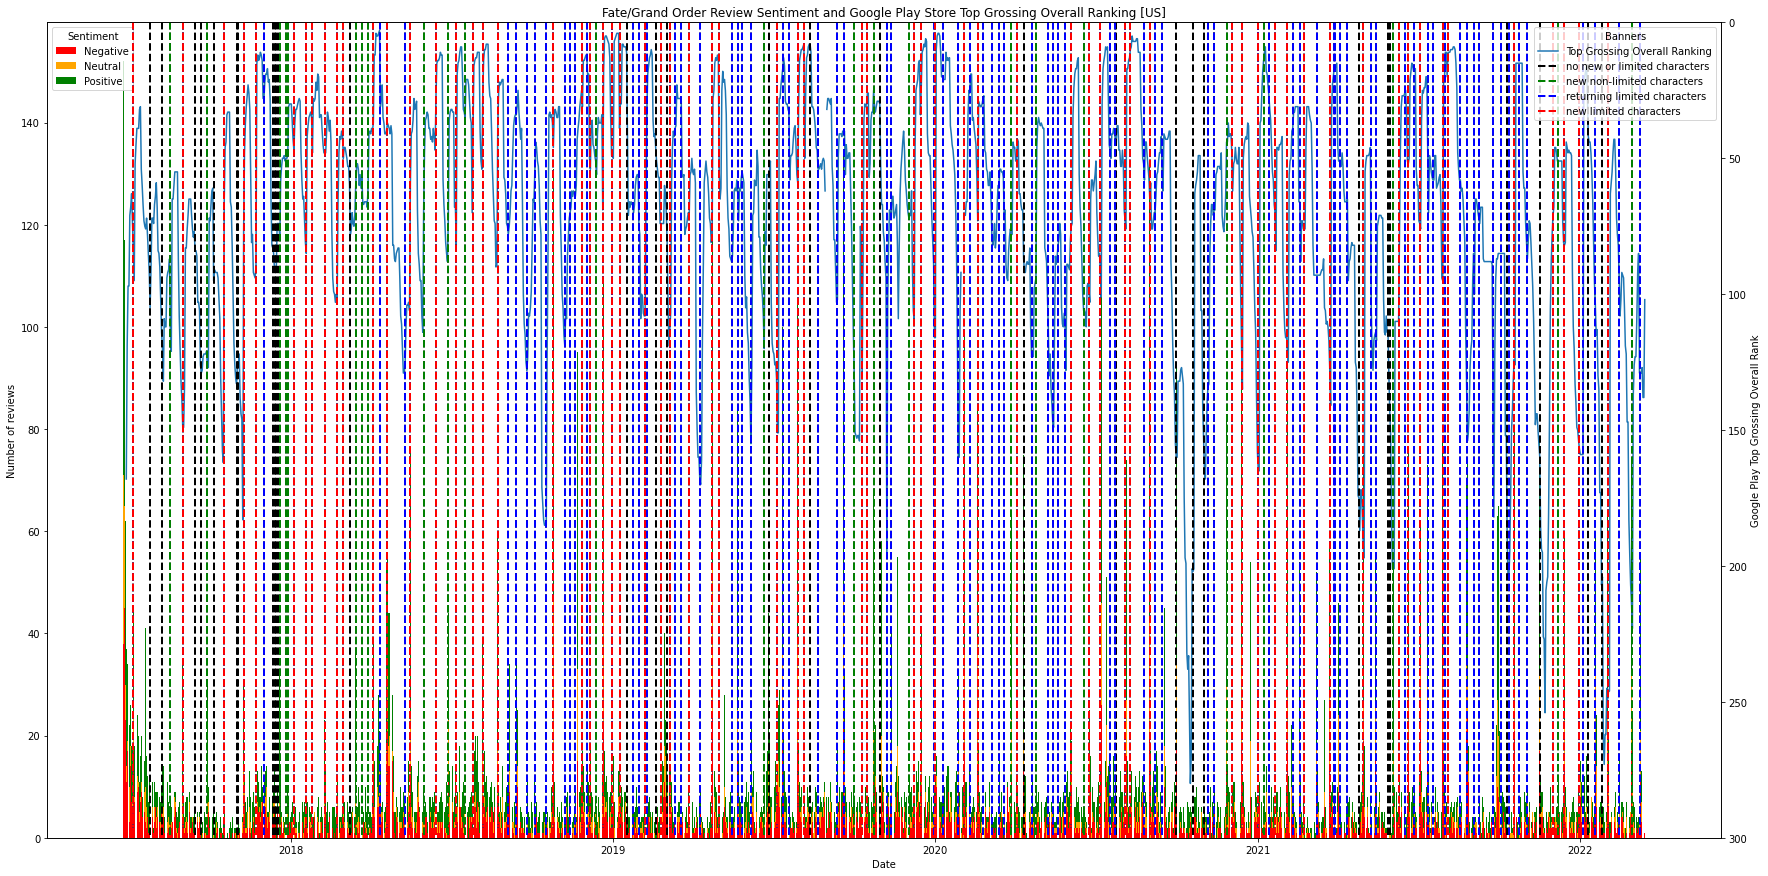

In [8]:
#plot entire timeline
plot_fgo(fgo_df)

This is very messy. Let's try dividing this graph by year to see if any patterns emerge.

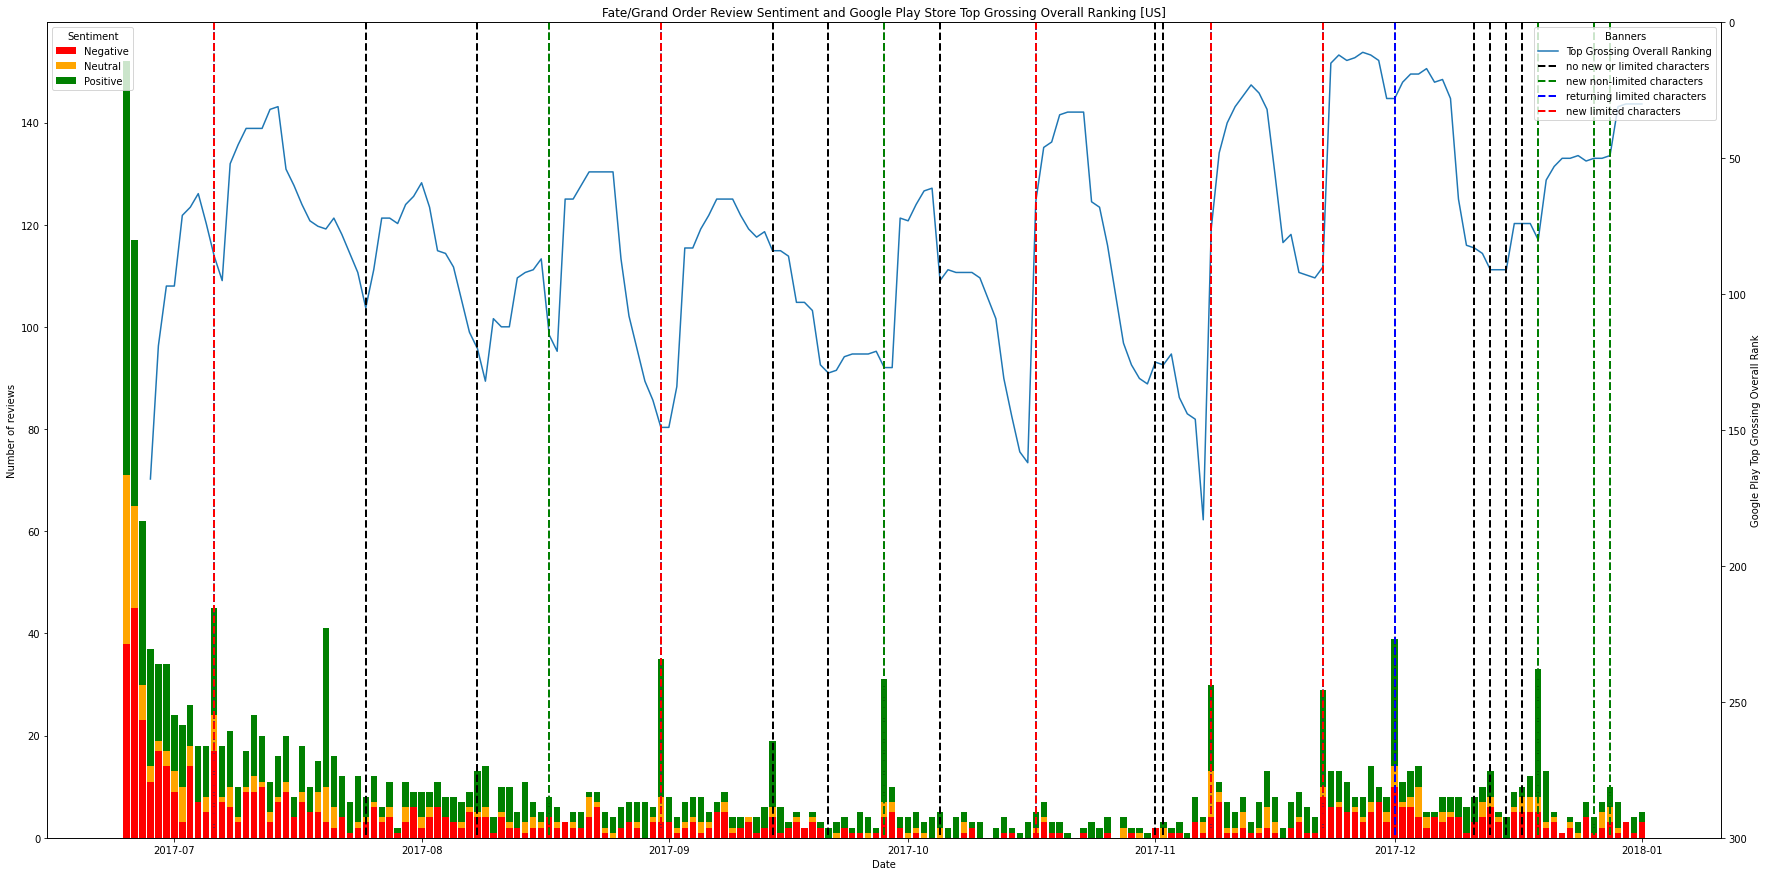

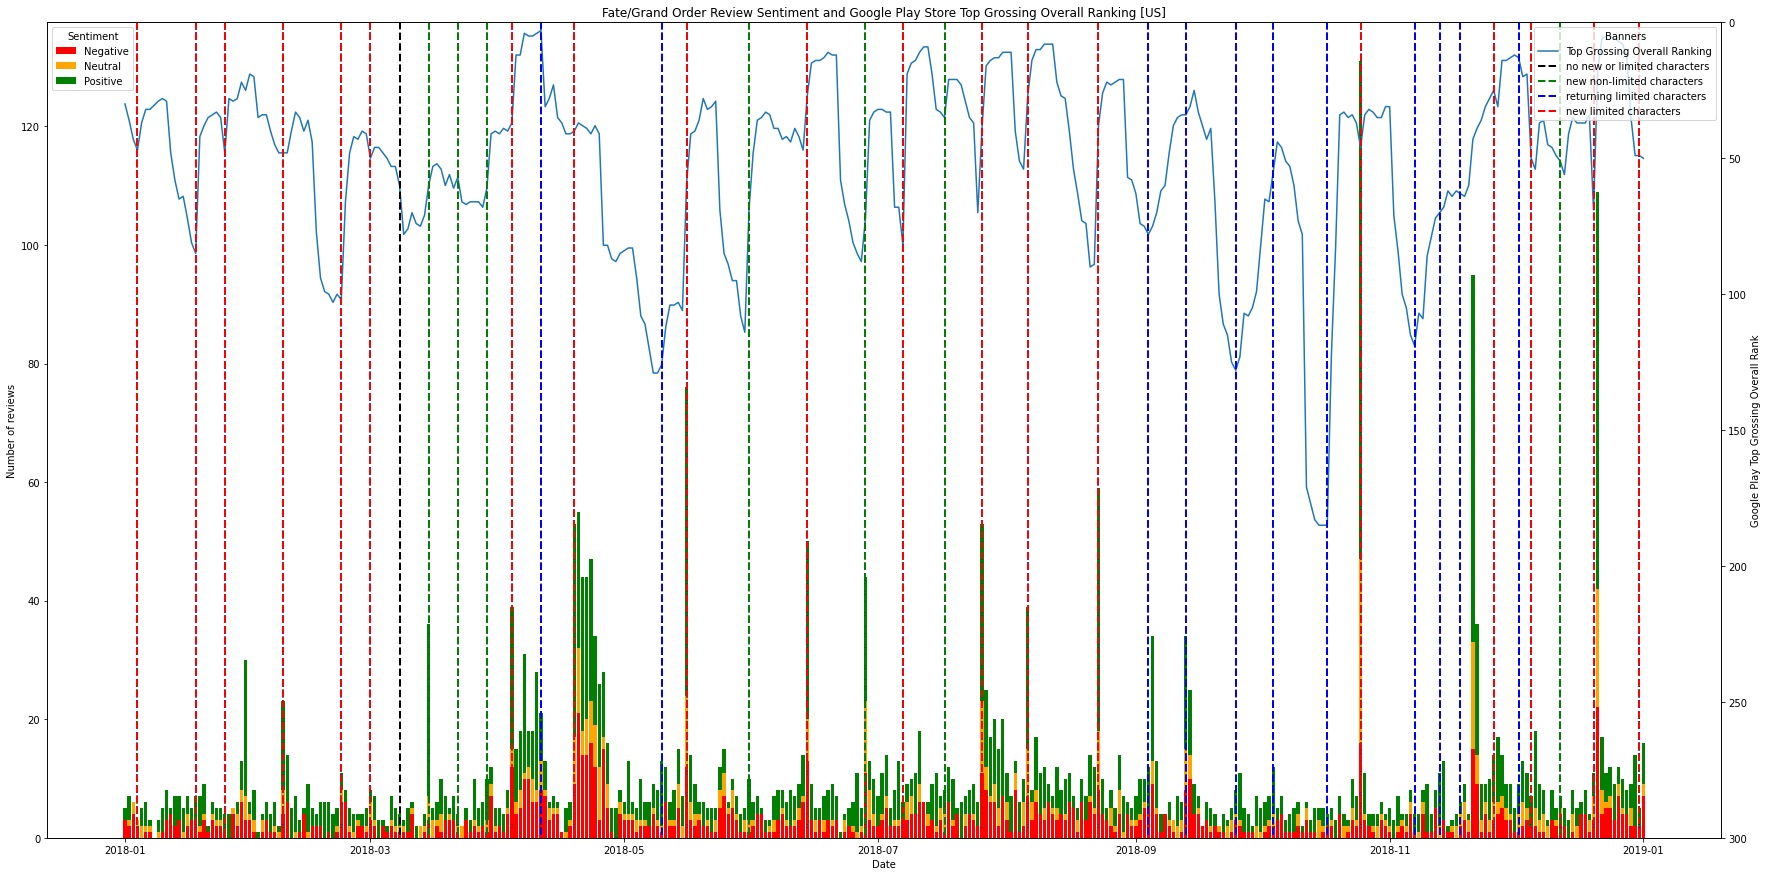

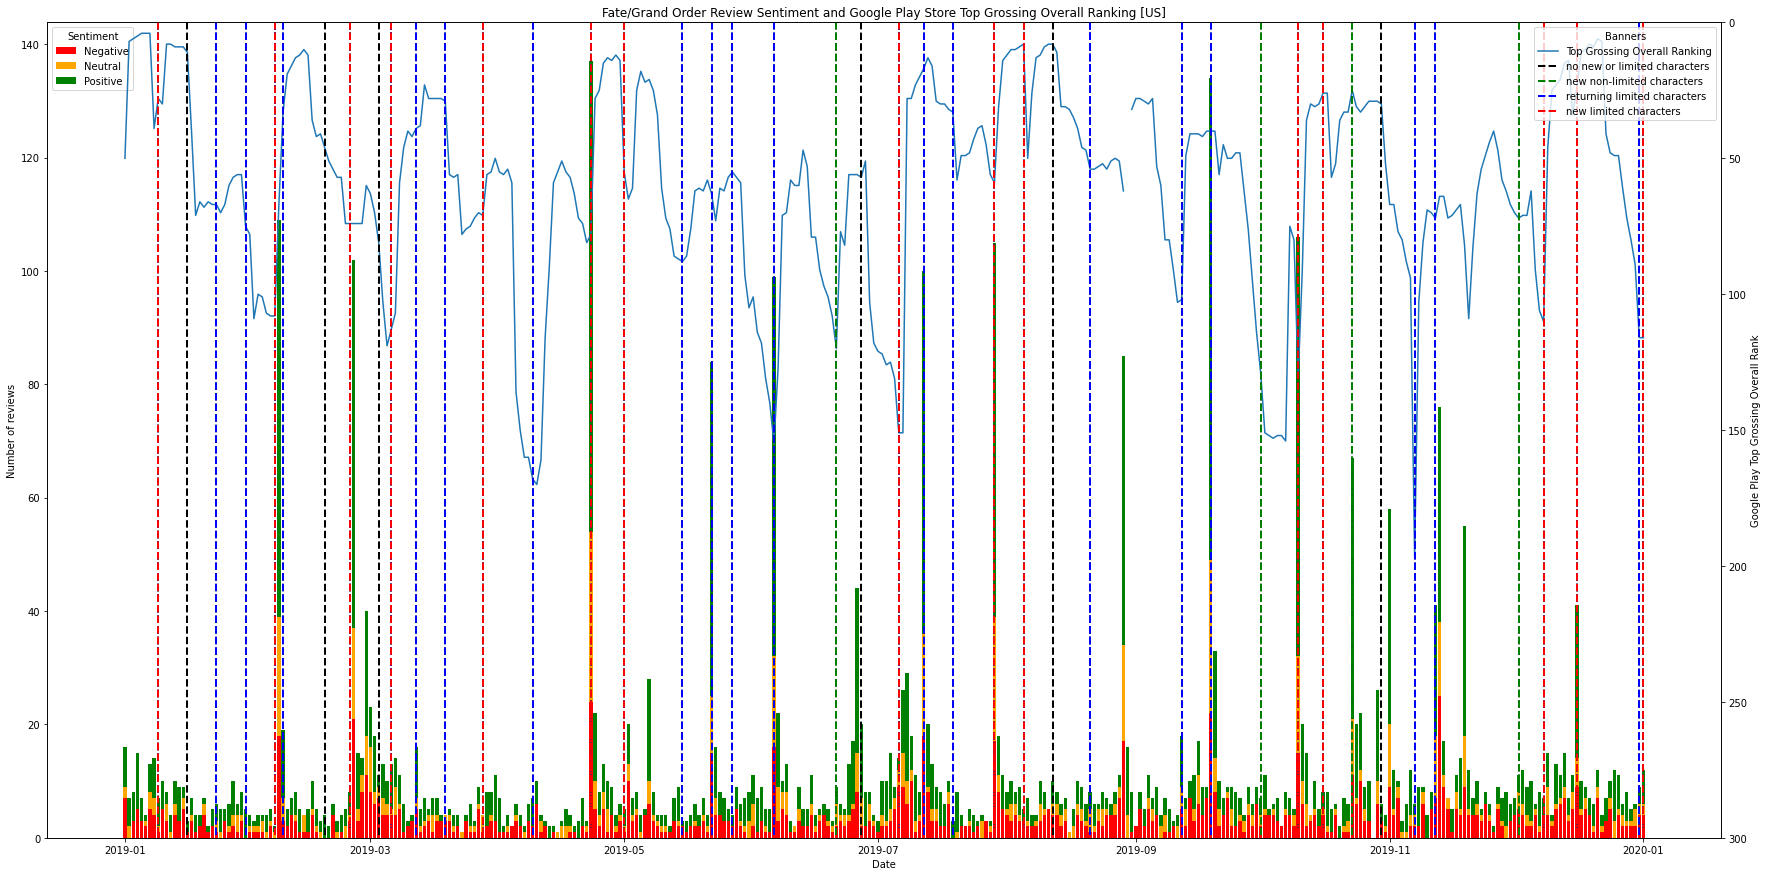

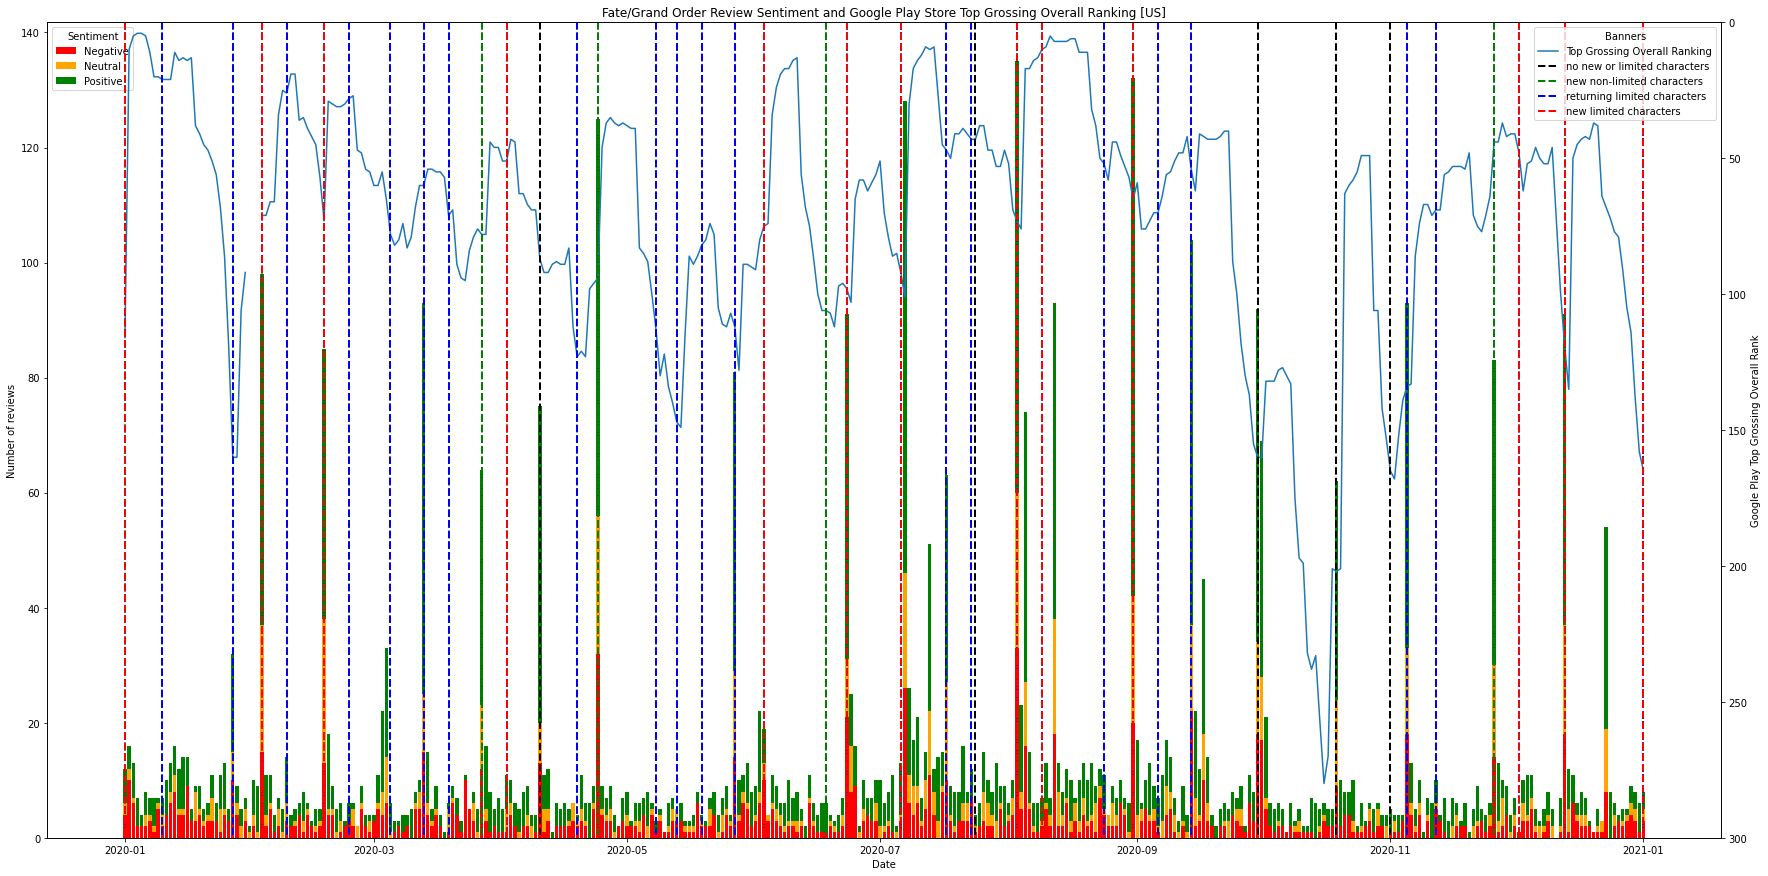

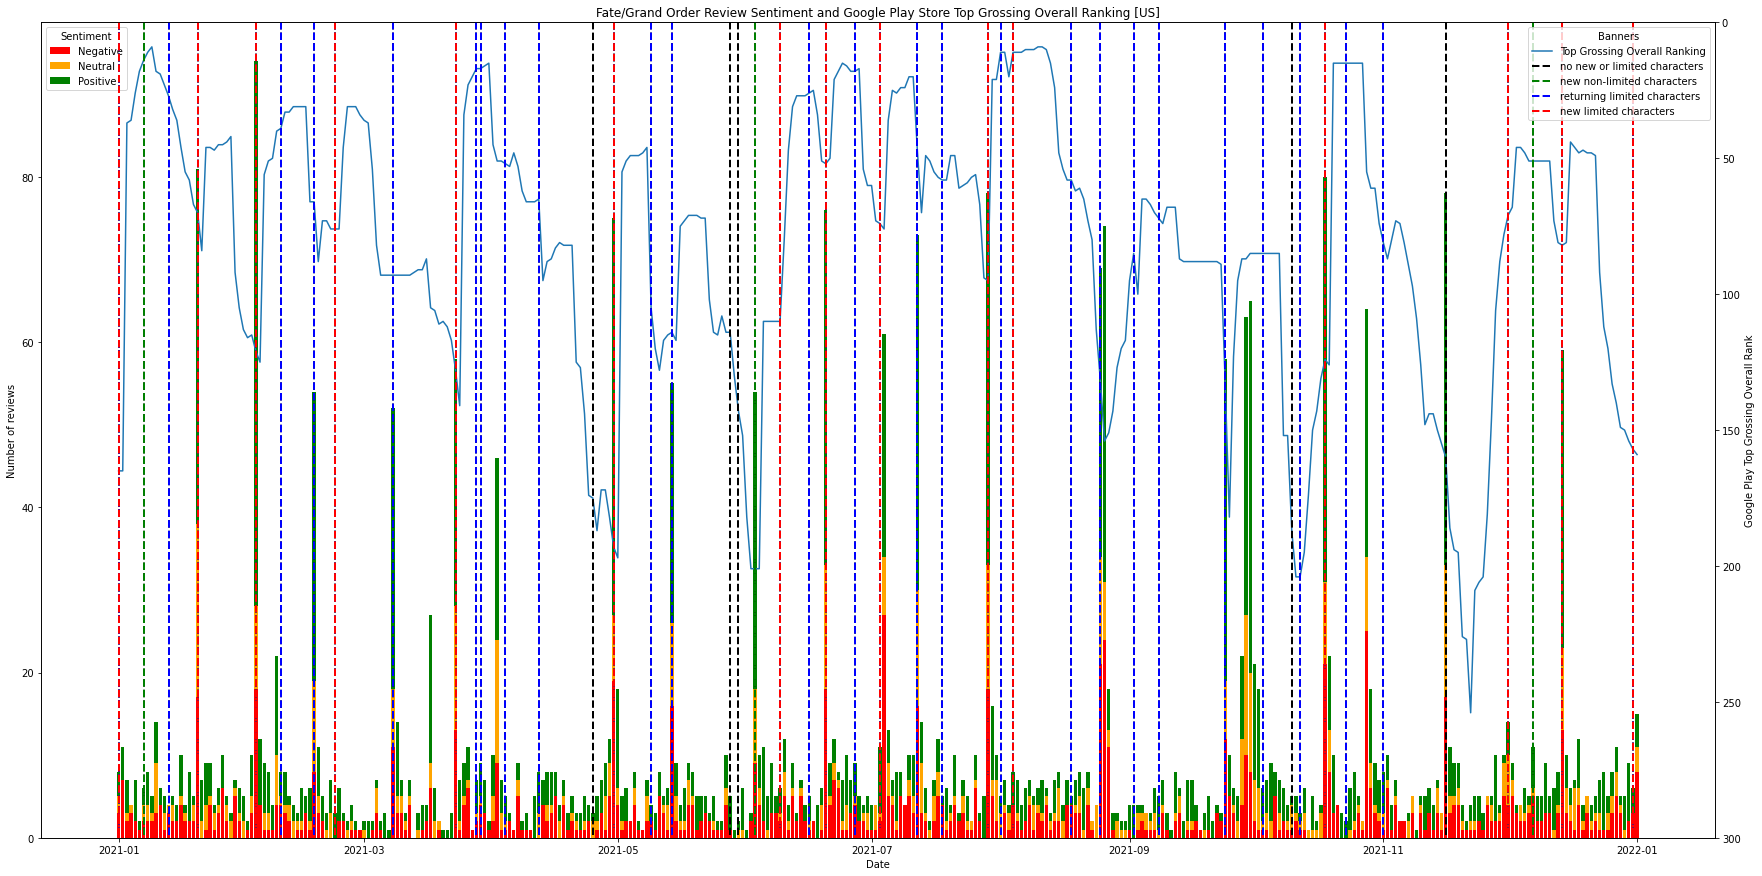

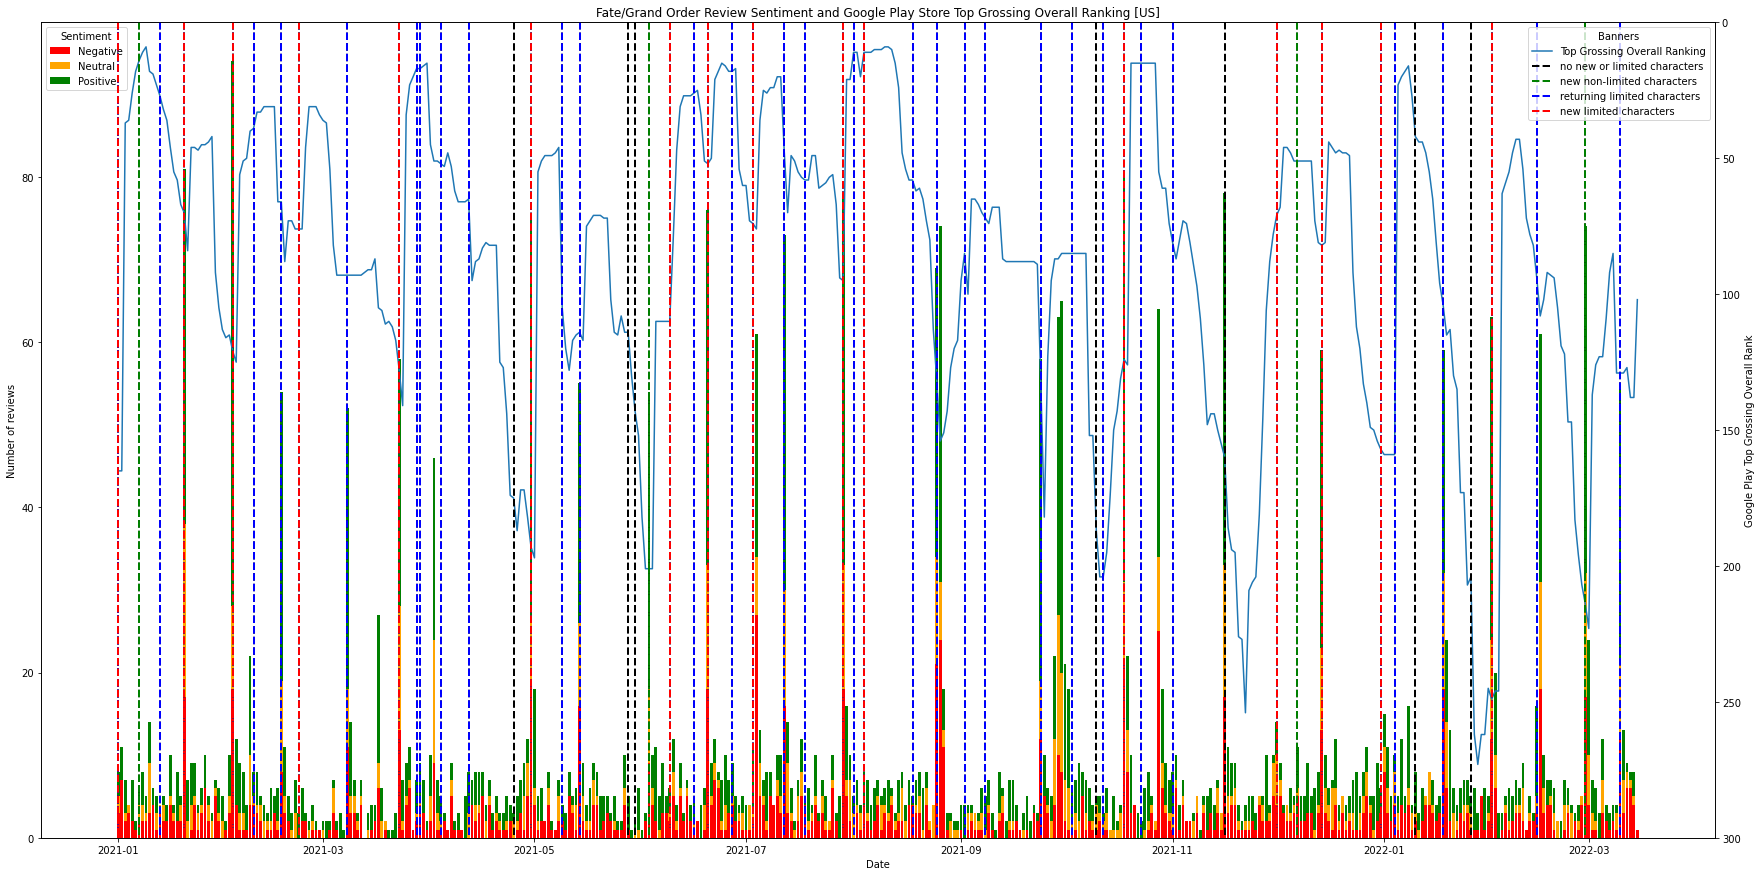

In [9]:
#split graph by year
split_df = [fgo_df.loc[:'2018-01-01'],
fgo_df.loc['2018-01-01':'2019-01-01'],
fgo_df.loc['2019-01-01':'2020-01-01'],
fgo_df.loc['2020-01-01':'2021-01-01'],
fgo_df.loc['2021-01-01':'2022-01-01'],
fgo_df.loc['2021-01-01':'2022-03-15']]

for df in split_df:
    plot_fgo(df)

### Statistical Analysis

In [10]:
#get Fate Grand Order events
events_df = pd.read_csv('Fate Grand Order Banner Calendar.csv').rename(columns = {'new_servant':'new', 'limited_servant':'limited'})
events_df['date'] = pd.to_datetime(events_df['date'])
events_df = events_df.set_index('date')

effect_df = events_df.loc[fgo_df.index[0]:fgo_df.index[-1]].reset_index().reset_index(drop=True)[['date','new','limited']]

#ranking 
ranking_pre = []
ranking_post = []

#sentiment
sent_pre = []
sent_post = []

for date in effect_df['date']:
    #ranking
    ranking_pre.append(max(fgo_df.loc[date - timedelta(days=5):date - timedelta(days=1)]['rank']))
    ranking_post.append(min(fgo_df.loc[date:date + timedelta(days=5)]['rank']))
    
    #sentiment
    sent_pre.append(min(fgo_df.loc[date - timedelta(days=5):date - timedelta(days=1)]['sentiment_count']))
    sent_post.append(max(fgo_df.loc[date:date + timedelta(days=5)]['sentiment_count']))
    
#ranking
effect_df['ranking_diff'] = -(np.array(ranking_post) - np.array(ranking_pre))

#sentiment
effect_df['sent_diff'] = (np.array(sent_post) - np.array(sent_pre))

effect_df = effect_df.replace({'new': {'yes': 1, 'no': 0}, 'limited': {'yes': 1, 'no': 0}})

In [11]:
#OLS model for ranking
import statsmodels.api as sm
import statsmodels.formula.api as smf

X = sm.add_constant(effect_df[['new', 'limited']])
model = smf.ols(formula='ranking_diff ~ new + limited + new:limited', data=effect_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           ranking_diff   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     7.965
Date:                Sun, 24 Apr 2022   Prob (F-statistic):           4.74e-05
Time:                        12:00:26   Log-Likelihood:                -1106.3
No. Observations:                 211   AIC:                             2221.
Df Residuals:                     207   BIC:                             2234.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      14.9032      8.306      1.794      0.074      -1.471      31.278
new            28.3468     12.573      2.255      0.025       3.559      53.135
limited        25.3301      9.630      2.630      0.009       6.344      44.316
new:limited    -5.6862     14.637     -0.388      0.698     -34.543      23.171
==============================================================================
Omnibus:                       48.978   Durbin-Watson:                   1.721
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               85.957
Skew:                           1.198   Prob(JB):                     2.16e-19
Kurtosis:                       5.008   Cond. No.                         9.16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Based on the model, we can conclude a few things. First, according to the F-statistic, this overall model is statistically significant. Second, banners with no new or limited characters (i.e. the intercept) is only weakly statistically significant (0.5 < p-value < 0.1) and claims that such banners increase the ranking by about 14.903 places on average. Third, banners with new characters increase the ranking by about 43.25 places on average; since the p-value < 0.05, we conclude this effect is statistically significant. Fourth, banners with limited characters increase the ranking by about 40.233 places on average; since the p-value < 0.05, we conclude this effect is statistically significant.

In [12]:
#OLS model for review volume
X = sm.add_constant(effect_df[['new', 'limited']])
model = smf.ols(formula='sent_diff ~ new + limited + new:limited', data=effect_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              sent_diff   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     3.156
Date:                Sun, 24 Apr 2022   Prob (F-statistic):             0.0258
Time:                        12:00:26   Log-Likelihood:                -1056.6
No. Observations:                 211   AIC:                             2121.
Df Residuals:                     207   BIC:                             2135.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      23.6452      6.563      3.603      0.000      10.706      36.584
new             9.4798      9.935      0.954      0.341     -10.107      29.067
limited         9.2104      7.610      1.210      0.228      -5.792      24.213
new:limited     3.8464     11.566      0.333      0.740     -18.956      26.649
==============================================================================
Omnibus:                       23.793   Durbin-Watson:                   1.861
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.065
Skew:                           0.896   Prob(JB):                     4.88e-07
Kurtosis:                       2.687   Cond. No.                         9.16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Based on the model, we can conclude that a generic banner will cause the number of reviews to increase by about 23.645 on average; since the p-value < 0.05, we can conclude this effect is statistically significant.